<center><h1><b>Tensorflow Input Pipeline</b></h1></center>

This is method handling huge dataset by using data input pipeline to load data batch by batch and it will be converted into special type data structure known as ```tf.data.Dataset.``` It uses some APIs like ```list_files``` for ingesting data, some custom functions using ``map`` for processing images,```filter``` to filter blurry images. The second step is using  ```fit``` to train the model. All of these operations will be done in a single line of code


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4329.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4223.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4253.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4190.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4354.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4136.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4226.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4214.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4888.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4170.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4323.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4262.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4788.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4657.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4387.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4255.jpg
/kaggle/

In [3]:
import os
import re
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras as ks
from tensorflow.keras import layers, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from tensorflow.keras.layers import BatchNormalization


%matplotlib inline

### Building tensorflow dataset

In [4]:
daily_sales_numbers = [21, 22, -108, 31, -1, 32, 34, 31]

In [5]:
# Building tf dataset from python list
tf_dataset = tf.data.Dataset.from_tensor_slices(daily_sales_numbers)
tf_dataset

<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int32, name=None)>

In [6]:
# printing the contents of the tensorflow dataset 
for sales in tf_dataset:  # as_numpy_iterator()  function can be used
    print(sales.numpy())

21
22
-108
31
-1
32
34
31


In [7]:
# To print some few elements from the tensorflow dataset
for sales in tf_dataset.take(3):
    print(sales.numpy())

21
22
-108


In [8]:
# To remove or filter out the datapoints that are negative
tf_dataset = tf_dataset.filter(lambda x: x > 0)
for sales in tf_dataset.as_numpy_iterator():
    print(sales) 
    

21
22
31
32
34
31


In [9]:
# To perform a kind of derived analysis on the existing datapoints using map function
tf_dataset = tf_dataset.map(lambda x: x * 72)  # any other wanted figure could be used
for sales in tf_dataset.as_numpy_iterator():
    print(sales)

1512
1584
2232
2304
2448
2232


In [10]:
# to shuffle the datapoints
tf_dataset = tf_dataset.shuffle(3)  # A buffer size ill be added to shuffle
for sales in tf_dataset.as_numpy_iterator():
    print(sales)

2232
2304
1512
2448
1584
2232


In [11]:
# To have the dataset in batches
for sales_batch in tf_dataset.batch(2): # this is useful when running multiple gpus to train dataset
    print(sales_batch.numpy())

[2232 1512]
[2304 2448]
[2232 1584]


### Performing all the operations or processes in a single line of pipeline

In [12]:
tf_data = tf.data.Dataset.from_tensor_slices(daily_sales_numbers)

In [13]:
# The data processing pipeline
tf_dataset = tf_data.filter(lambda x: tf.reduce_all(x > 0)).map(lambda y: y * 72).shuffle(2).batch(2)

for sales in tf_dataset.as_numpy_iterator():
    print(sales)

[1512 1584]
[2232 2448]
[2304 2232]


## Creating Directories and Moving the Cats and Dogs Datasets Into Them

In [14]:
# Root directory
input_dir = '/kaggle/input/cat-and-dog'

# Check contents of the root directory and subdirectories
for root, dirs, files in os.walk(input_dir):
    print(f"Directory: {root}")
    for name in dirs:
        print(f"  Sub-directory: {name}")

Directory: /kaggle/input/cat-and-dog
  Sub-directory: test_set
  Sub-directory: training_set
Directory: /kaggle/input/cat-and-dog/test_set
  Sub-directory: test_set
Directory: /kaggle/input/cat-and-dog/test_set/test_set
  Sub-directory: dogs
  Sub-directory: cats
Directory: /kaggle/input/cat-and-dog/test_set/test_set/dogs
Directory: /kaggle/input/cat-and-dog/test_set/test_set/cats
Directory: /kaggle/input/cat-and-dog/training_set
  Sub-directory: training_set
Directory: /kaggle/input/cat-and-dog/training_set/training_set
  Sub-directory: dogs
  Sub-directory: cats
Directory: /kaggle/input/cat-and-dog/training_set/training_set/dogs
Directory: /kaggle/input/cat-and-dog/training_set/training_set/cats


In [15]:
# Define paths
input_dir = '/kaggle/input/cat-and-dog'
output_dir = '/kaggle/working'

# Clean up: Remove all existing directories in the output directory
for directory in os.listdir(output_dir):
    dir_path = os.path.join(output_dir, directory)
    if os.path.isdir(dir_path):
        shutil.rmtree(dir_path)

# Create only the new 'cats' and 'dogs' directories
cats_dir = os.path.join(output_dir, 'cats')
dogs_dir = os.path.join(output_dir, 'dogs')
os.makedirs(cats_dir, exist_ok=True)
os.makedirs(dogs_dir, exist_ok=True)

# List of subdirectories to check
sub_dirs = ['test_set/test_set', 'training_set/training_set']

# Move cat and dog images to their respective combined directories
for sub_dir in sub_dirs:
    src_cats_dir = os.path.join(input_dir, sub_dir, 'cats')
    src_dogs_dir = os.path.join(input_dir, sub_dir, 'dogs')

    # Copy cat images to the new 'cats' directory
    for cat_file in os.listdir(src_cats_dir):
        cat_file_path = os.path.join(src_cats_dir, cat_file)
        if os.path.isfile(cat_file_path):
            shutil.copy(cat_file_path, os.path.join(cats_dir, cat_file))

    # Copy dog images to the new 'dogs' directory
    for dog_file in os.listdir(src_dogs_dir):
        dog_file_path = os.path.join(src_dogs_dir, dog_file)
        if os.path.isfile(dog_file_path):
            shutil.copy(dog_file_path, os.path.join(dogs_dir, dog_file))

print("All cat and dog images have been successfully organized into 'cats' and 'dogs' directories.")

All cat and dog images have been successfully organized into 'cats' and 'dogs' directories.


##### Reading the images

In [16]:
# Supplying and reading images
images_ds = tf.data.Dataset.list_files('/kaggle/working/*/*', shuffle=True)  # The shuffle can be changed to False depending on the situation
 
for file in images_ds.take(3 ):
    print(file.numpy())

b'/kaggle/working/dogs/dog.3274.jpg'
b'/kaggle/working/cats/cat.1641.jpg'
b'/kaggle/working/cats/cat.438.jpg'


In [17]:
images_ds = images_ds.shuffle(200)

for file in images_ds.take(3):
    print(file.numpy())

b'/kaggle/working/cats/cat.1137.jpg'
b'/kaggle/working/dogs/dog.1797.jpg'
b'/kaggle/working/cats/cat.851.jpg'


### Dataset Processing

In [18]:
class_names = ['cat', 'dog']

In [19]:
image_count = len(images_ds)
image_count

10030

In [20]:
# To select 80% of the dataset as training dataset and the rest for test dataset
train_size = int(image_count * 0.8)

train_ds = images_ds.take(train_size)
test_ds = images_ds.skip(train_size)

In [21]:
len(train_ds), len(test_ds)

(8024, 2006)

In [22]:
s = '/kaggle/working/dogs/dog.5.jpg'

# Split by both '/' and '.'
split_parts = re.split(r'[/.]', s)[-3]  # Using re library and split function to split string with multiple delimiters
split_parts

'dog'

In [23]:
# Split operation on tensorflow dataset
s = '/kaggle/working/dogs/dog.5.jpg'

# Split by '/' and then by '.'
split_path = tf.strings.split(s, os.path.sep)
filename = split_path[-1]  # Last element: 'dog.5.jpg'
name_only = tf.strings.split(filename, '.')[0]  # First part before '.'

name_only

<tf.Tensor: shape=(), dtype=string, numpy=b'dog'>

In [24]:
# Function to extract label from file paths
def get_label(file_path):
    split_path = tf.strings.split(file_path, os.path.sep)
    filename = split_path[-1]
    label = tf.strings.split(filename, '.')[0]
    return label

In [25]:
# Calling get_label function on train dataset
for label in train_ds.map(get_label).take(3):
    print(label.numpy())

b'cat'
b'dog'
b'cat'


In [26]:
# Function to process the images in line with the label extracted
def process_image(file_path):
    labels = get_label(file_path)
    
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, [128, 128])
    
    return img, labels

In [27]:
# Calling process_image function on train dataset to process the images and extract their labels
train_ds = train_ds.map(process_image)
for img, label in train_ds.take(1):
    print(img)
    print(label)

tf.Tensor(
[[[207.00732  212.00732  215.00732 ]
  [146.42236  151.42236  154.42236 ]
  [213.53662  218.53662  221.53662 ]
  ...
  [ 46.254395  28.504395  39.504395]
  [ 71.56152   42.374023  37.936523]
  [134.33105   97.643555  70.206055]]

 [[127.336914 132.33691  135.33691 ]
  [211.79248  216.79248  219.79248 ]
  [148.42676  153.42676  156.42676 ]
  ...
  [ 40.59912   21.872559  30.59375 ]
  [ 83.70166   54.51416   48.07959 ]
  [129.31299   94.62549   67.53076 ]]

 [[160.97998  165.97998  168.97998 ]
  [226.10986  231.10986  234.10986 ]
  [ 85.47119   90.47119   93.47119 ]
  ...
  [ 37.306152  16.993652  20.179688]
  [ 99.421875  69.296875  58.083496]
  [132.58936  101.19629   73.473145]]

 ...

 [[217.0669   222.0669   225.0669  ]
  [187.31836  192.31836  195.31836 ]
  [218.30225  223.30225  226.30225 ]
  ...
  [222.50195  221.50195  217.50195 ]
  [203.26758  202.26758  198.26758 ]
  [205.2041   204.2041   200.2041  ]]

 [[170.49854  175.49854  178.49854 ]
  [218.8086   223.8086   2

In [28]:
# Function to scale the images
def scale(image, label):
    return image/255, label

In [29]:
train_ds = train_ds.map(scale)

for image, label in train_ds.take(5):
    print('***Image: ', image.numpy()[0][0])
    print('**Label: ', label.numpy())

***Image:  [0.85188967 0.8832622  0.89110535]
**Label:  b'cat'
***Image:  [0.22734112 0.10617077 0.01041535]
**Label:  b'cat'
***Image:  [0.31322572 0.3044022  0.33443627]
**Label:  b'dog'
***Image:  [0.06072304 0.04111519 0.01758578]
**Label:  b'cat'
***Image:  [0.18808474 0.16832502 0.19193037]
**Label:  b'cat'


## An Input Pipeline to Perform all the functions Above

#### A compact pipeline

In [30]:
# A Compact Pipeline

# Define the classes and image path
class_names = ['cat', 'dog'] 
image_path = '/kaggle/working/*/*'

# Compact Data Processing Pipeline
tf_dataset = (
    tf.data.Dataset.list_files(image_path, shuffle=True)
    .map(lambda file_path: (tf.image.resize(tf.image.decode_jpeg(tf.io.read_file(file_path)), [128, 128]) / 255, 
                            tf.strings.split(tf.strings.split(file_path, os.path.sep)[-1], '.')[0]), 
         num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .shuffle(buffer_size=1000)
    .batch(batch_size=32)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

for sales in tf_dataset.take(1):
    print(sales)

(<tf.Tensor: shape=(32, 128, 128, 3), dtype=float32, numpy=
array([[[[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         ...,
         [0.99607843, 0.99607843, 0.99607843],
         [0.99607843, 0.99607843, 0.99607843],
         [0.99607843, 0.99607843, 0.99607843]],

        [[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         ...,
         [0.99607843, 0.99607843, 0.99607843],
         [0.99607843, 0.99607843, 0.99607843],
         [0.99607843, 0.99607843, 0.99607843]],

        [[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         ...,
         [0.99607843, 0.99607843, 0.99607843],
         [0.99607843, 0.99607843, 0.99607843],
         [0.99607843, 0.99607843, 0.99607843]],

        ...,

        [[0.99607843, 0.99607843

#### Comprehensive Input Pipeline

In [31]:
# Define the path to images and class names
image_path = '/kaggle/working/*/*.jpg'  # Filter for .jpg files only

# Step 1: Load the image file paths
images_ds = tf.data.Dataset.list_files(image_path, shuffle=True)  # Load paths to images and shuffle

# Step 2: Function to decode images, resize them, and scale pixel values
def process_image(file_path):
    img = tf.io.read_file(file_path)
    
    try:
        img = tf.image.decode_jpeg(img, channels=3)  # Decode as JPEG with RGB channels
        img = tf.image.resize(img, [128, 128])       # Resize to fixed dimensions
        img = img / 255.0                             # Scale to [0, 1]
    except tf.errors.InvalidArgumentError:
        return None
    return img

# Step 3: Function to extract label from file path
def get_label(file_path):
    split_path = tf.strings.split(file_path, os.path.sep)
    filename = split_path[-1]
    label_str = tf.strings.split(filename, '.')[0]  # Extract 'cat' or 'dog'
    label = tf.cond(label_str == 'cat', lambda: 0, lambda: 1)  # Convert label to binary (0 for cat, 1 for dog)
    return label

# Step 4: Combine image processing and label extraction in a single function
def process_path(file_path):
    img = process_image(file_path)
    label = get_label(file_path)
    return img, label

# Step 5: Define data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.5),
    layers.RandomRotation(0.2),
    layers.RandomFlip("horizontal_and_vertical")
])

# Step 6: Apply processing, augmentation, and batching in the pipeline
def prepare_dataset(dataset, augment=False):
    dataset = (dataset
               .map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)
               .filter(lambda img, label: img is not None)  # Filter out None images
               .shuffle(buffer_size=1000)
               .batch(batch_size=32)
               .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    )
    # Apply augmentation only if augment is set to True
    if augment:
        dataset = dataset.map(lambda img, label: (data_augmentation(img, training=True), label), 
                              num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return dataset

# Step 7: Split dataset into training and testing
image_count = len(images_ds)
train_size = int(image_count * 0.8)

train_ds = images_ds.take(train_size)
test_ds = images_ds.skip(train_size)

# Step 8: Prepare train and test datasets
train_dataset = prepare_dataset(train_ds, augment=True)  # Enable augmentation for training set
test_dataset = prepare_dataset(test_ds)  # No augmentation for test set

In [32]:
# Count number of batches in batched datasets
num_train_batches = sum(1 for _ in train_dataset)
num_test_batches = sum(1 for _ in test_dataset)

# Calculate total number of images in each dataset
total_train_images = num_train_batches * 32
total_test_images = num_test_batches * 32

print(f"Estimated number of images in the train dataset: {total_train_images}")
print(f"Estimated number of images in the test dataset: {total_test_images}")

Estimated number of images in the train dataset: 8032
Estimated number of images in the test dataset: 2016


## Training the Model

In [33]:
def get_model():
    model = Sequential([
        layers.Input(shape=(128, 128, 3)),
        
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        BatchNormalization(),
        layers.MaxPooling2D(),
        
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        BatchNormalization(),
        layers.MaxPooling2D(),
        
        layers.Conv2D(128, 3, padding='same', activation='relu'),
        BatchNormalization(),
        layers.MaxPooling2D(),
        
        layers.Conv2D(256, 3, padding='same', activation='relu'),
        BatchNormalization(),
        layers.MaxPooling2D(),
        
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [34]:
# Function to plot training & validation accuracy and loss curves
def plot_training_graphs(model):
    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(model.history['accuracy'], label='Train Accuracy')
    plt.plot(model.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(model.history['loss'], label='Train Loss')
    plt.plot(model.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend();

In [35]:
# Training and evaluation function with distributed strategy
def train_and_evaluate_model(train_dataset, test_dataset, epochs, learning_rate):
    checkpoint_callback = ModelCheckpoint(
        'Best_custom_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
    with strategy.scope():
        gpu_model = get_model()
        model_train = gpu_model.fit(
            train_dataset, 
            epochs=epochs, 
            validation_data=test_dataset, 
            callbacks=[checkpoint_callback]
        )
    best_model = load_model('Best_custom_model.keras')
    loss, accuracy = best_model.evaluate(test_dataset)
    print(f'Best Accuracy: {accuracy * 100:.2f}%')
    print(f'Best Loss: {loss:.4f}')
    # Assuming you have a function called `plot_training_graphs`
    plot_training_graphs(model_train) 
    return best_model 

Epoch 1/10
    251/Unknown 33s 75ms/step - accuracy: 0.5158 - loss: 5.6804

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 1: val_accuracy improved from -inf to 0.50548, saving model to Best_custom_model.keras
251/251 ━━━━━━━━━━━━━━━━━━━━ 35s 85ms/step - accuracy: 0.5158 - loss: 5.6726 - val_accuracy: 0.5055 - val_loss: 0.7873
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.5238 - loss: 1.0146
Epoch 2: val_accuracy improved from 0.50548 to 0.52243, saving model to Best_custom_model.keras
251/251 ━━━━━━━━━━━━━━━━━━━━ 22s 83ms/step - accuracy: 0.5238 - loss: 1.0141 - val_accuracy: 0.5224 - val_loss: 0.6949
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5270 - loss: 0.7553
Epoch 3: val_accuracy improved from 0.52243 to 0.57926, saving model to Best_custom_model.keras
251/251 ━━━━━━━━━━━━━━━━━━━━ 21s 82ms/step - accuracy: 0.5270 - loss: 0.7553 - val_accuracy: 0.5793 - val_loss: 0.6840
Epoch 4/10
250/251 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5333 - loss: 0.7210
Epoch 4: val_accuracy did not improve from 0.57926
251/251 ━━━━━━━━━━━━━━━━━━━━ 21s 82ms/step - 

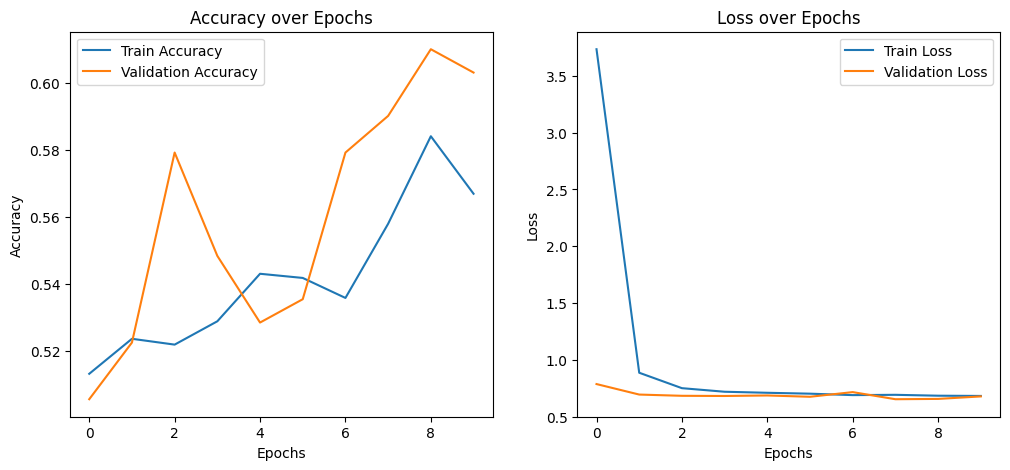

In [36]:
# Parameters
image_size = (128, 128)
num_classes = 2
epochs = 10
learning_rate = 0.001
strategy = tf.distribute.MirroredStrategy()

# Train the model
custom_best_model = train_and_evaluate_model(train_dataset, test_dataset, epochs=epochs, learning_rate=learning_rate) 

In [39]:
labels_dict = {
    'cat': 0,
    'dog': 1
}

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


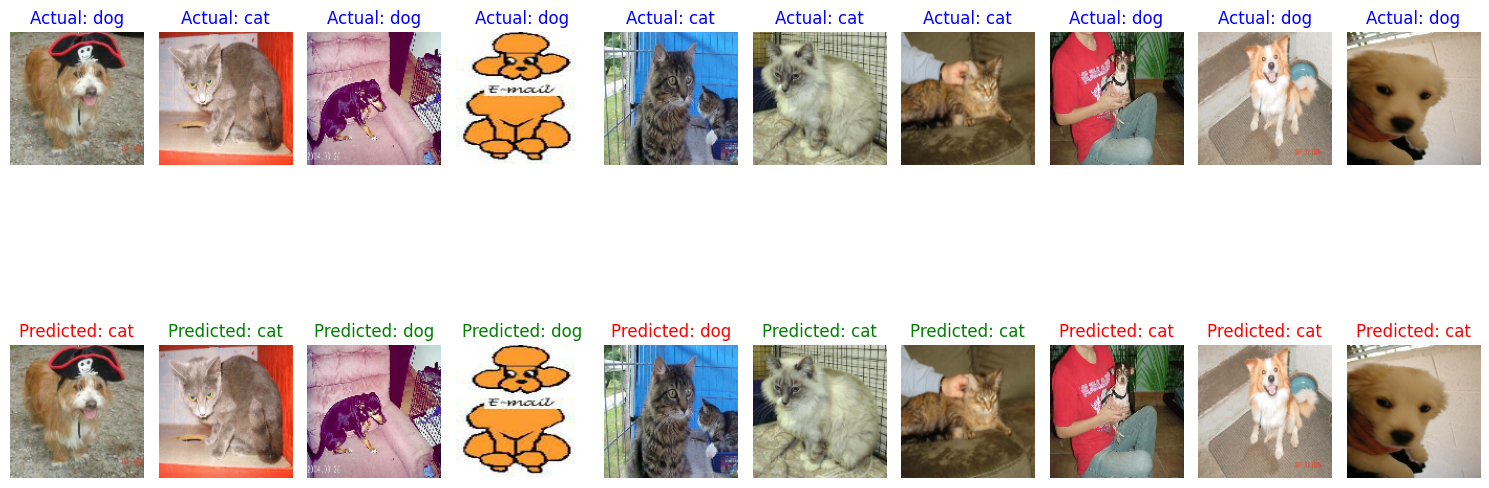

In [40]:
# Adjusted `get_label` function
def get_label(file_path):
    # Extract 'cat' or 'dog' from the filename
    split_path = tf.strings.split(file_path, os.path.sep)
    filename = split_path[-1]
    label_str = tf.strings.split(filename, '.')[0]  # Extract 'cat' or 'dog'
    label = labels_dict.get(label_str.decode('utf-8'), -1)  # Use labels_dict, with -1 for unmatched labels
    return label

# Updated `predictions_and_actuals` function to ensure correct image and label association
def predictions_and_actuals(model, test_dataset, labels_dict, num_images=10):
    # Create reverse mapping from numeric labels to string labels
    reverse_labels_dict = {v: k for k, v in labels_dict.items()}
    
    predicted_images, actual_images, predictions, actuals = [], [], [], []
    
    for X_test_batch, y_test_batch in test_dataset:
        if len(predicted_images) >= num_images:
            break

        batch_predictions = model.predict(X_test_batch)
        predicted_classes = np.argmax(batch_predictions, axis=1)

        for i in range(len(X_test_batch)):
            if len(predicted_images) >= num_images:
                break
            
            # Append the images and labels for correct association
            predicted_images.append(X_test_batch[i].numpy())
            actual_images.append(X_test_batch[i].numpy())
            predictions.append(predicted_classes[i])
            actuals.append(y_test_batch[i].numpy())

    # Display the images and associated labels
    plt.figure(figsize=(15, 8))
    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        img_actual = actual_images[i]
        img_actual = (img_actual * 255).astype('uint8') if np.max(img_actual) <= 1.0 else img_actual
        plt.imshow(img_actual)
        plt.axis('off')
        plt.title(f'Actual: {reverse_labels_dict[actuals[i]]}', color="blue")
        
        plt.subplot(2, num_images, i + 1 + num_images)
        img_pred = predicted_images[i]
        img_pred = (img_pred * 255).astype('uint8') if np.max(img_pred) <= 1.0 else img_pred
        plt.imshow(img_pred)
        plt.axis('off')
        plt.title(f'Predicted: {reverse_labels_dict[predictions[i]]}', color="green" if predictions[i] == actuals[i] else 'red')
    
    plt.tight_layout()
    plt.show()

    # Call the function to display predicted and actual labels with label-specific images
predictions_and_actuals(custom_best_model, test_dataset, labels_dict) 

<center><h1>Input Pipeline Optimization Using Cache</h1></center>

Cache will help opening, reading, and mapping of data to be done once at the first epoch instead of repeating these steps at every epoch when dataset is being trained.

In [41]:
tf.__version__

'2.16.1'

In [42]:
import time

In [58]:
# Base class
class FileDataset(tf.data.Dataset):
    def read_files_in_batches(num_samples):
        # Open file
        time.sleep(0.03)
        for sample_idx in range(num_samples):
            time.sleep(0.015)
            yield (sample_idx,)
            
    def __new__(cls, num_samples=3):
        return tf.data.Dataset.from_generator(
        cls.read_files_in_batches,
        output_signature = tf.TensorSpec(shape = (1,), dtype = tf.int64),
            args = (num_samples,)
        )

In [59]:
def benchmark(dataset, num_epochs=2):
    for epoch_num in range(num_epochs):
        for sample in dataset:
            time.sleep(0.01)

In [60]:
%%timeit
benchmark(FileDataset())

243 ms ± 994 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [61]:
%%timeit
benchmark(FileDataset().prefetch(1))

244 ms ± 1.23 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [65]:
%%timeit
benchmark(FileDataset().prefetch(tf.data.AUTOTUNE))

243 ms ± 363 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Cache

In [70]:
dataset = tf.data.Dataset.range(5)
for d in dataset:
    print(d.numpy())

0
1
2
3
4


In [72]:
# Finding square of numbers in dataset
dataset = dataset.map(lambda x: x**2)
for d in dataset:
    print(d.numpy())

0
1
4
9
16


In [73]:
dataset = dataset.cache()
list(dataset.as_numpy_iterator())

[0, 1, 4, 9, 16]

In [74]:
list(dataset.as_numpy_iterator())

[0, 1, 4, 9, 16]

In [77]:
def mapped_function(s):
    tf.py_function(lambda: time.sleep(0.03), [], ())
    return s

In [79]:
%%timeit
benchmark(FileDataset().map(mapped_function), 5)

1.05 s ± 2.06 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [80]:
%%timeit
benchmark(FileDataset().map(mapped_function).cache(), 5)

370 ms ± 914 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
